## Setting Vram for memory growth


In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-05 20:54:53.865555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 20:54:53.865580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 20:54:53.866274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 20:54:53.949200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

## Visualising and loading training & testing data from cifar10 dataset

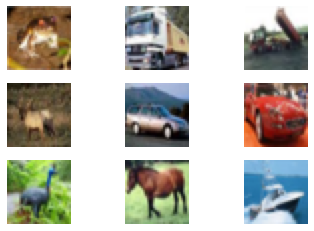

In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot 

(train_x, train_y), (test_x, test_y) = load_data()

for i in range(9):
    pyplot.subplot(3,3,i+1)
    pyplot.axis('off')
    pyplot.imshow(train_x[i])

pyplot.show()

## Importing basic dependencies

In [3]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Dense, Flatten, Dropout, LeakyReLU
from keras.utils import plot_model
import numpy as np

## Building Discriminator model

In [4]:
# 32*32 res images in cifar dataset with 3 channels for RGB as default input shape

def discriminator_nn(in_shape=(32,32,3)): 
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape)) # 64 filters of 3*3 kernel size
    model.add(LeakyReLU(alpha=0.2))

    # downsample; strided convolutions instead of maxpooling2D
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # strides=(2,2) -> downsample by factor of 2; 32->16
    model.add(LeakyReLU(alpha=0.2))

    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same')) # 16->8
    model.add(LeakyReLU(alpha=0.2))

    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same')) # 8->4
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4)) # to avoid overfitting
    model.add(Dense(1, activation='sigmoid')) # 0 -> fake,imag; 1 -> real image
    
    # compile model
    optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    
    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

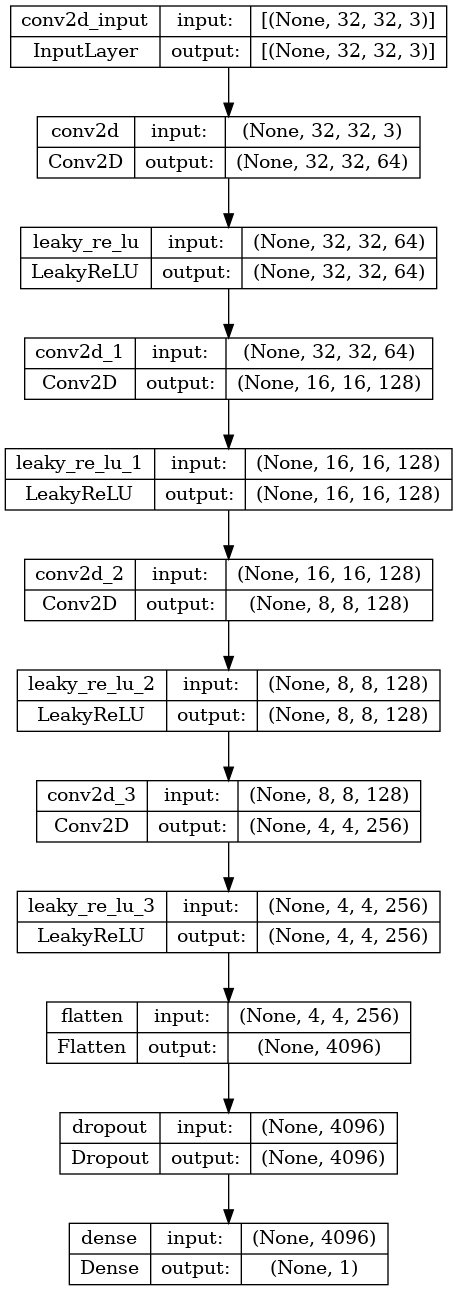

In [5]:
model = discriminator_nn()
model.summary()
plot_model(model, to_file='discriminator_nn.png', show_shapes=True, show_layer_names=True)

    Conv2D Layer 1:
        Filters: 64
        Kernel size: 3x3
        Input channels: 3 (assuming RGB image)
        Parameters = (3 * 3 * 3 + 1) * 64 = 1792

    Conv2D Layer 2:
        Filters: 128
        Kernel size: 3x3
        Input channels: 64 (output channels from the previous layer)
        Parameters = (3 * 3 * 64 + 1) * 128 = 73856

    Conv2D Layer 3:
        Filters: 128
        Kernel size: 3x3
        Input channels: 128
        Parameters = (3 * 3 * 128 + 1) * 128 = 147584

    Conv2D Layer 4:
        Filters: 256
        Kernel size: 3x3
        Input channels: 128
        Parameters = (3 * 3 * 256 + 1) * 128 = 295168

    Dense Layer:
        Input neurons: 4 * 4 * 128 (output size from the last Conv2D layer)
        Output neurons: 1
        Parameters = (4 * 4 * 128 + 1) * 1 = 2049

Now, let's sum up these parameters:

1792+73856+147584+295168+2049=522497

## Loading training samples and cycling through the discriminator

In [6]:
# preprocessing real data

def load_real_samples():
    (train_x, _), (_, _) = load_data() # _ -> don't care about labels
    X = train_x.astype('float32') # int to float32
    X = (X - 127.5) / 127.5 # scale from [0,255] to [-1,1]; as we r gonna use tanh activation in generator
    return X

In [7]:
X = load_real_samples()

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples) # random nos from 0 to dataset.shape[0] of size n_samples
    X = dataset[ix] # select random images
    y = np.ones((n_samples, 1)) # class labels 1 for real images for discriminator
    return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 3) (64, 1) [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


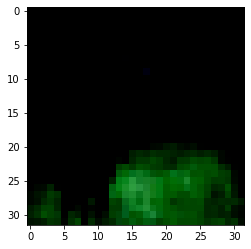

In [9]:
X,y = generate_real_samples(X, 64)
print(X.shape, y.shape,y)
pyplot.imshow(X[0])

In [10]:
# this function is just to visualise fake data / noise data
def generate_fake_samples(n_samples):
    X = np.random.rand(32*32*3*n_samples) # random nos from 0 to dataset.shape[0] of size n_samples
    X = -1 + X*2 # scale from [0,1] to [-1,1]
    X = X.reshape((n_samples, 32, 32, 3)) # reshape to 32*32*3
    y = np.zeros((n_samples, 1)) # class labels 0 for fake images for discriminator
    return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 3) (64, 1) [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


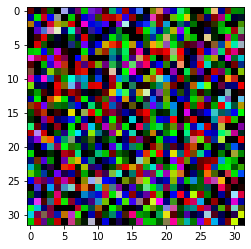

In [11]:
X, y = generate_fake_samples(64)
print(X.shape, y.shape, y)
pyplot.imshow(X[0])

In [12]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2) # half training on real & fake images
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch) 
        _, real_accuracy = model.train_on_batch(X_real, y_real) # weight update
        X_fake, y_fake = generate_fake_samples(half_batch) 
        _, fake_accuracy = model.train_on_batch(X_fake, y_fake) # weight update
        print('%d real=%.0f%% fake=%.0f%%' % (i+1, real_accuracy*100, fake_accuracy*100))

In [13]:
model = discriminator_nn()
dataset = load_real_samples()
train_discriminator(model, dataset)

1 real=77% fake=0%
2 real=100% fake=5%
3 real=100% fake=16%
4 real=95% fake=36%
5 real=95% fake=77%
6 real=95% fake=95%
7 real=91% fake=100%
8 real=95% fake=100%
9 real=91% fake=100%
10 real=89% fake=100%
11 real=95% fake=100%
12 real=97% fake=100%
13 real=97% fake=100%
14 real=100% fake=100%
15 real=97% fake=100%
16 real=100% fake=100%
17 real=98% fake=100%
18 real=100% fake=100%
19 real=100% fake=100%
20 real=100% fake=100%


## Building Generator Model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU # Conv2DTranspose -> upsampling/upscaling images
from keras.utils import plot_model

In [15]:
def generator_nn(latent_dim):
    model = Sequential()

    n_nodes = 256*4*4 # 256 filters of 4*4 kernel size
    model.add(Dense(n_nodes, input_dim=latent_dim)) # input layer
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256))) # reshape to 4*4*256

    # upsample to 8*8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # 128 filters of 4*4 kernel size; 4->8
    model.add(LeakyReLU(alpha=0.2))

    # 128 filters of 4*4 kernel size; 8*8->16*16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # 128 filters of 4*4 kernel size; 16*16->32*32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same')) # 3 channels for RGB
    
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

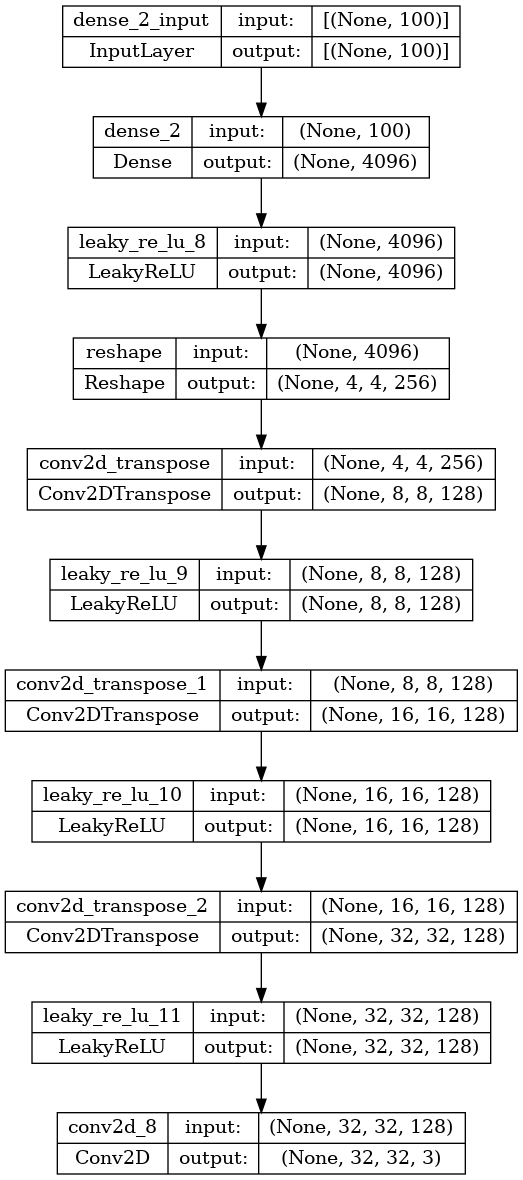

In [16]:
latent_dim = 100
model = generator_nn(latent_dim)
model.summary()
plot_model(model, to_file='generator_nn.png', show_shapes=True, show_layer_names=True)

    Dense Layer (Dense):
        Output Shape: (None, 4096)
        Parameters: input_dim*n_nodes+ n_nodes = 100*4096 + 4096 = 413696
        Explanation: The Dense layer takes an input of size latent_dim (assumed to be 100) and maps it to a densely connected layer with 4096 neurons.

    LeakyReLU Activation (LeakyReLU):
        Output Shape: (None, 4096)
        No trainable parameters. The LeakyReLU introduces non-linearity to the output of the dense layer.

    Reshape Layer (Reshape):
        Output Shape: (None, 4, 4, 256)
        No trainable parameters. The Reshape layer transforms the output from the dense layer into a 4x4x256 tensor.

    Conv2DTranspose Layer (Conv2DTranspose):
        Output Shape: (None, 8, 8, 128)
        Parameters: kernel size×input channels×output channels+output channels=4×256×128+128=524416kernel size×input channels×output channels+output channels=4×256×128+128=524416
        Explanation: The Conv2DTranspose layer is used for upsampling. It takes the 4x4x256 tensor and upsamples it to 8x8x128.

    LeakyReLU Activation (LeakyReLU):
        Output Shape: (None, 8, 8, 128)
        No trainable parameters. Another LeakyReLU introduces non-linearity.

    Conv2DTranspose Layer (Conv2DTranspose):
        Output Shape: (None, 16, 16, 128)
        Parameters: kernel size×input channels×output channels+output channels=4×128×128+128=262272kernel size×input channels×output channels+output channels=4×128×128+128=262272
        Explanation: Another Conv2DTranspose layer for further upsampling.

    LeakyReLU Activation (LeakyReLU):
        Output Shape: (None, 16, 16, 128)
        No trainable parameters. Another LeakyReLU introduces non-linearity.

    Conv2DTranspose Layer (Conv2DTranspose):
        Output Shape: (None, 32, 32, 128)
        Parameters: kernel size×input channels×output channels+output channels=4×128×128+128=262272kernel size×input channels×output channels+output channels=4×128×128+128=262272
        Explanation: Yet another Conv2DTranspose layer for more upsampling.

    LeakyReLU Activation (LeakyReLU):
        Output Shape: (None, 32, 32, 128)
        No trainable parameters. Another LeakyReLU introduces non-linearity.

    Conv2D Layer (Conv2D):
        Output Shape: (None, 32, 32, 3)
        Parameters: kernel size×input channels×output channels+output channels=4×128×3+3=3459kernel size×input channels×output channels+output channels=4×128×3+3=3459
        Explanation: The final Conv2D layer that outputs a 32x32x3 tensor representing the generated image.

    Total Parameters:
        413696+524416+262272+262272+3459=1466115413696+524416+262272+262272+3459=1466115 (5.59 MB)

This generator network takes a random noise vector as input and generates a 32x32x3 image as output. The Conv2DTranspose layers are used for upsampling to gradually increase the spatial dimensions. LeakyReLU activations introduce non-linearity, and the final Conv2D layer produces the output image

In [17]:
def generate_latent_points(latent_dim, n_samples): #col*row
    x_input = np.random.randn(latent_dim * n_samples) # random nos from 0 to dataset.shape[0] of size n_samples
    x_input = x_input.reshape(n_samples, latent_dim) # reshape to n_samples*latent_dim
    return x_input
# gives vectors of size 100 (latent_dim) for 100 samples and converts them to images of size 32*32*3

In [18]:
x_input = generate_latent_points(100,64)
print(x_input.shape)

(64, 100)


In [19]:
def generate_fake_samples_using_generator(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input) # generate images
    y = np.zeros((n_samples, 1)) # class labels 0 for fake images for discriminator
    return X, y

## Plotting generated images

2/2 [==============================] - 0s 68ms/step


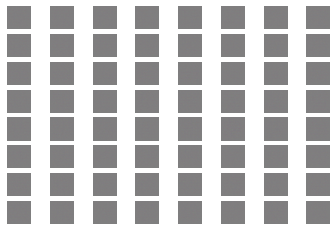

In [23]:
latent_dim = 100
model = generator_nn(latent_dim)
n_samples = 64
X, y = generate_fake_samples_using_generator(generator=model, latent_dim=latent_dim, n_samples=n_samples) # generate images

X = (X+1)/2.0 # scale from [-1,1] to [0,1]

# plot the generated samples

for i in range(n_samples):
    pyplot.subplot(8,8,i+1)
    pyplot.axis('off')
    pyplot.imshow(X[i])

pyplot.show()

## Training the GAN (Generator & Discriminator)

In [24]:
# trains the composite model
def GAN(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimiser)
    return model

The above composite model of generator & discriminator only updates the weights of generator

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


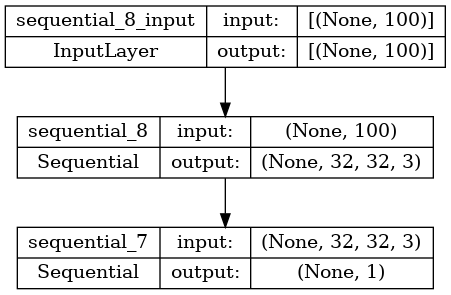

In [27]:
latent_dim = 100
discriminator = discriminator_nn()
generator = generator_nn(latent_dim)
gan_model = GAN(generator, discriminator)
gan_model.summary()
plot_model(gan_model, to_file='gan_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [29]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [30]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples_using_generator(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1)) # gives false input for fake image as real image
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [31]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator_nn()
# create the generator
g_model = generator_nn(latent_dim)
# create the gan
gan_model = GAN(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 107ms/step


2023-12-05 21:27:13.788558: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-12-05 21:27:13.917916: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-12-05 21:27:14.136167: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


>1, 1/390, d1=0.683, d2=0.696 g=0.693
2/2 [==============================] - 0s 87ms/step


2023-12-05 21:27:15.482039: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-12-05 21:27:15.610950: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


>1, 2/390, d1=0.633, d2=0.697 g=0.693
2/2 [==============================] - 0s 173ms/step
>1, 3/390, d1=0.576, d2=0.698 g=0.692
2/2 [==============================] - 0s 88ms/step
>1, 4/390, d1=0.482, d2=0.699 g=0.691
2/2 [==============================] - 0s 88ms/step
>1, 5/390, d1=0.374, d2=0.701 g=0.689
2/2 [==============================] - 0s 81ms/step
>1, 6/390, d1=0.226, d2=0.701 g=0.687
2/2 [==============================] - 0s 87ms/step
>1, 7/390, d1=0.117, d2=0.696 g=0.684
2/2 [==============================] - 0s 87ms/step
>1, 8/390, d1=0.054, d2=0.690 g=0.679
2/2 [==============================] - 0s 86ms/step
>1, 9/390, d1=0.020, d2=0.686 g=0.671
2/2 [==============================] - 0s 117ms/step
>1, 10/390, d1=0.017, d2=0.680 g=0.661
2/2 [==============================] - 0s 93ms/step
>1, 11/390, d1=0.011, d2=0.675 g=0.648
2/2 [==============================] - 0s 88ms/step
>1, 12/390, d1=0.008, d2=0.667 g=0.632
2/2 [==============================] - 0s 103ms/step
>1, 

## Final generator model to generate images


In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator


def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images


def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()


# load model
# model = load_model('generator_model_200.h5')
model = load_model('generator_model_010.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)